## Self-Driving behavioral cloning

This will show how I set up the pipeline to produce data, normalize data, creating a model and train the model.

To achieve a goal of simulating the car steering angle to drive the autonomous car around the lap successfully on the road without touching the side of the road.

Most of the python code functions are in `model.py` file in the same path. I will capture the snippet of the code here or just run the `python model.py` to load data and train model and at the end, we will have `model.h5` saved.

In [1]:
#local python file
%matplotlib inline
import model as mymodel

Using TensorFlow backend.


### Visualize raw data and characteristics

From `load_data` below the function will expect location of images. Although I have data for left and right camera but I use only the center camera images for this project. 

I decided to separate data into 3 buckets
1. `data_v3` this is a normal drive around the lap counter-clockwise and clockwise directions 2 rounds. Why version 3 I'm glad you ask. The first 2 versions I put all data in one bucket and that's really hard to add more data to each strategy.
2. `curve_drive` is the data focus on driving on the curve road only.
3. `side_drive` this is to add more data to correct the behavior of the car when on side of the road to come back to the middle of the roads.

This strategy allows me to correct particular data then mix-and-match data to see the different images captured from driving from keyboard compared to the mouse. 

At the end, after comparing driving result driving with mouse gave a very good result due to the fact that mouse movement gave a smooth continuous steering angle comparing to the keyboard. 

let see a sample of the images as we can see later on in the model set up, I will crop out the image so we don't have to pay attention to the part of images like a tree, sky.

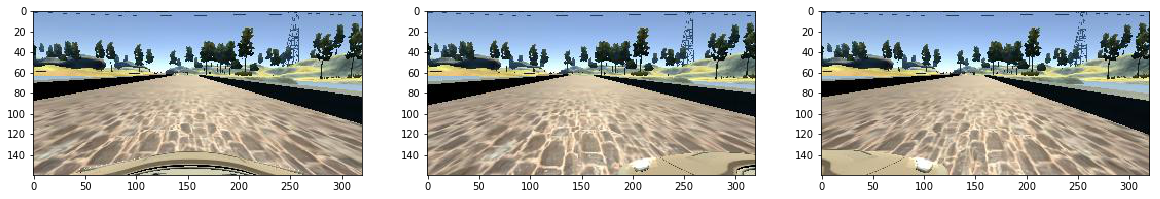

In [2]:
data = mymodel.load_data(['./data_v3', './curve_drive', './side_drive']) 
mymodel.visualize_data(data)

#### Distribution of raw data 

Next, I have looked at distribution of steering angle data from -1.00 to 1.00

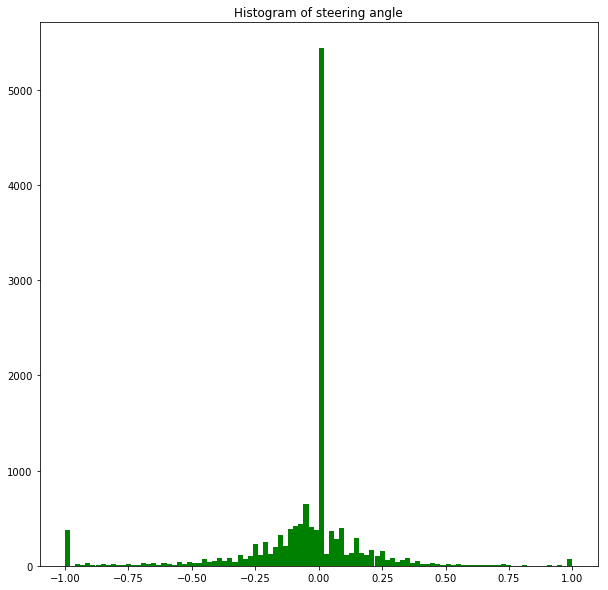

In [3]:
mymodel.visualize_histogram(data)

##### Clean up data

It seems that we have a lot of data at 0.00 angle so to avoid a car making bias on the straight line as possible. I will apply random filter out 70% of the data.

a snippet of the code below 

```
random_prob = random.random()
angel = float(l[3])
if (angel == 0.0 and random_prob <= 0.3) or (abs(angel) == 1.0 and random_prob <= 0.1) or (abs(angel) > 0.0 and abs(angel) < 1.0):
   ...
```

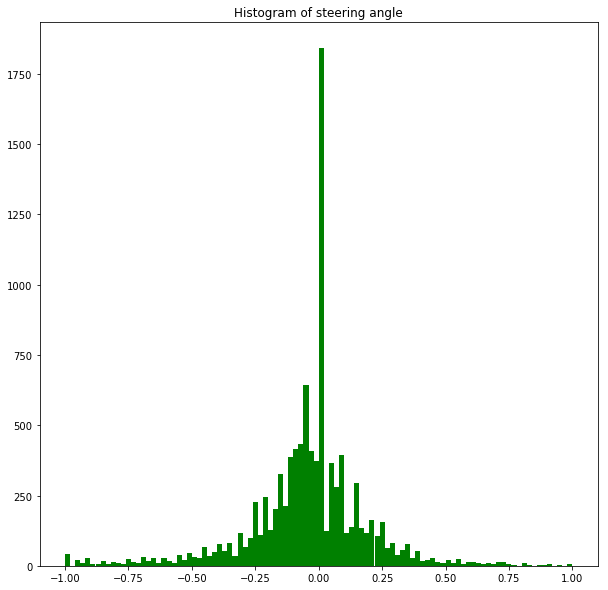

In [4]:
data = mymodel.load_data_normalize(['./data_v3', './curve_drive', './side_drive']) 
mymodel.visualize_histogram(data)

### Processing data and Generator

After visualizing data, for memory efficiency, I have created Generator for training and validation data.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

train_samples, validation_samples = train_test_split(data, test_size=0.2)
train_generator = mymodel.generator(train_samples, batch_size=16)
validation_generator = mymodel.generator(validation_samples, batch_size=16)

### Model 

At this stage, I have data ready to be trained. For the model, I have tried several models starting from the simple network just to get the project going and see how we can set up the whole process of training.

#### Simple network

Just a fully dense network

```
def simple_network(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) -0.5, input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    return model
```

#### LeNet network

I choose LeNet to train next because LeNet has a very good in recognizing image with details as 
1. First doing normalize data with Lambda 
2. Cropping image 50 pixels from the top and 20 pixels from the bottom because data outside of road are not important like the tree, sky for example.
3. Add 5 by 5 CNN with 6 filters then apply Rectified linear activation function
4. Add Dropout layer to ignore 20% of the network to avoid overfitting.
5. Add 5 by 5 CNN with 12 filters then apply Rectified linear activation function
6. Add MaxPooling and then Dropout layer to ignore 20% of the network to avoid overfitting.
7. Add 5 by 5 CNN with 24 filters then apply Rectified linear activation function
8. Add MaxPooling and then Dropout layer to ignore 20% of the network to avoid overfitting.
9. Flatten network before passing through Dense network
10. Add Dense layer of 120 and 84 units with Rectified linear activation function
11. Lastly, add 1 unit of the Dense layer as we want to output a value of car steering angle.

```
def lenet_network(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: (x /255.0) - 0.5, input_shape = input_shape))
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    model.add(Convolution2D(6,5,5, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(12,5,5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Convolution2D(24,5,5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(1))
    return model
```

#### Nvidia network

After training with LeNet network for a while, I realize I cannot make a car running smoothly and the next model recommended by Nvidia team for the Self-Driving car so let give it a try.

The model itself is very much like LeNet network 

1. First I apply normalize function to data with Lambda and crop out the image.
2. Add CNN 5 by 5 kernel with 24 filters and apply Rectified linear activation function lastly add Dropout to avoid overfitting 30% ignoring the network.
3. Add CNN 5 by 5 kernel with 36 filters and apply Rectified linear activation function lastly add Dropout to avoid overfitting 30% ignoring the network.
4. Add CNN 5 by 5 kernel with 48 filters and apply Rectified linear activation function lastly add Dropout to avoid overfitting 30% ignoring the network.
5. Add 2 layers of CNN 5 by 5 kernel with 64 filters and apply Rectified linear activation function lastly add Dropout to avoid overfitting 30% ignoring the network.
6. Flatten network before passing to the Dense network of 100, 50, 10 and lastly 1 unit for output the steering angle.

```
def nvidia_network(input_shape):
    model = Sequential()
    model.add(Lambda(lambda x: (x /255.0) - 0.5, input_shape = input_shape))
    model.add(Cropping2D(cropping =((70,25), (0,0))))
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    return model
```

## Train and visualize

For last and best network trained, I choose Nvidia network as explained before as my model.

I chose `Adam` optimizer so the per-parameter learning rate methods provide heuristic approach without requiring expensive work in tuning hyperparameters for the learning rate schedule manually. For loss function, I chose `mse` or mean squared error as loss function so we will train model to minimize the error of the steering angle.

```
model.compile(loss='mse', optimizer='adam')
```

Next, training with `fit_generator` by providing train and validation generator. 

```
history_data = model.fit_generator(train_generator, samples_per_epoch=train_size,validation_data=validation_generator, nb_val_samples=validation_size,nb_epoch=epoch, verbose=1)
```

I'm training my model with 20 epochs as result below.

In [6]:
model = mymodel.nvidia_network((160, 320, 3))
# The size of train and validation are double because at generator I add flipping images for every images.
history_data = mymodel.train_with_generator(train_generator, validation_generator, 
                                    len(train_samples)*2, len(validation_samples)*2, 
                                    epoch=20, model=model)

Epoch 1/20
16352/16352 [==============================] - 36s - loss: 0.0377 - val_loss: 0.0287
Epoch 2/20
16352/16352 [==============================] - 26s - loss: 0.0326 - val_loss: 0.0270
Epoch 3/20
16352/16352 [==============================] - 26s - loss: 0.0305 - val_loss: 0.0252
Epoch 4/20
16352/16352 [==============================] - 26s - loss: 0.0299 - val_loss: 0.0271
Epoch 5/20
16352/16352 [==============================] - 26s - loss: 0.0296 - val_loss: 0.0253
Epoch 6/20
16352/16352 [==============================] - 26s - loss: 0.0281 - val_loss: 0.0244
Epoch 7/20
16352/16352 [==============================] - 26s - loss: 0.0278 - val_loss: 0.0246
Epoch 8/20
16352/16352 [==============================] - 26s - loss: 0.0272 - val_loss: 0.0235
Epoch 9/20
16352/16352 [==============================] - 26s - loss: 0.0272 - val_loss: 0.0244
Epoch 10/20
16352/16352 [==============================] - 26s - loss: 0.0272 - val_loss: 0.0233
Epoch 11/20
16352/16352 [==============

## visualize(history_data)

From the loss graph below, after 10 epoch I cannat see the improvement so this might be a sign for more data to train on like getting new data on second lap.

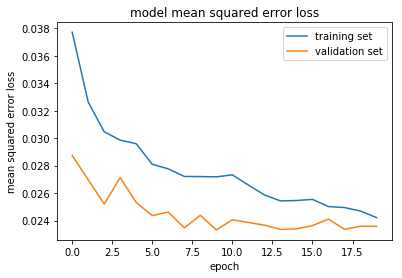

In [7]:
mymodel.visualize_loss(history_data)

### Result

The result shown above is the final attempts of the experiment and training.

At first, after 2 laps of gathering driving and training. I found that training with LeNet and Nvidia, the latter gave me a smoother movement but both models caused the car to pass the bridge but couldn't finish the lap and went through the side of the road. So I chose Nvidia model as my main model for later and all experiments.

I decided to split data into 3 buckets as mentioned above. This allowed me to focus on rectifying each bucket without worrying about others. I re-recorded the driving around the lap 3 times (version 3 of data) because I used keyboard maneuver yielding less accurate result comparing to the mouse.

Next, I visualized data as histogram I found that data is not distributed nicely so I did filter data especially center steering 0.00 angle.

At last, my training model .h5 can help automatically drive a car around the lap at least 20 plus laps successfully (counter-clockwise and clockwise) however I captured video of only one lap as in videos folder.